<a href="https://colab.research.google.com/github/mohanrajmit/Rainstreaks_Removal/blob/main/rainstreaks_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/mohanrajmit/Rainstreaks_Removal.git

Cloning into 'Rainstreaks_Removal'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 28 (delta 1), reused 25 (delta 1), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [3]:
cd /content/Rainstreaks_Removal

/content/Rainstreaks_Removal


In [4]:
ls

car11.png  GuidedFilter.py  README.md   TestData/   TrainData/
car8.jpg   model/           readme.txt  testing.py  training.py


In [5]:
import os
import skimage
import numpy as np
import tensorflow as tf
import training as Network
import matplotlib.pyplot as plt


In [6]:

os.environ['CUDA_VISIBLE_DEVICES'] = "0"  # select GPU device


tf.reset_default_graph()

model_path = './model/'
pre_trained_model_path = './model/trained/model'

In [7]:

img_path = './TestData/input/' # the path of testing images
results_path = './TestData/results/' # the path of de-rained images

In [8]:
def _parse_function(filename):   
  image_string = tf.read_file(filename)  
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)  
  rainy = tf.cast(image_decoded, tf.float32)/255.0 
  return rainy 


1
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
INFO:tensorflow:Res

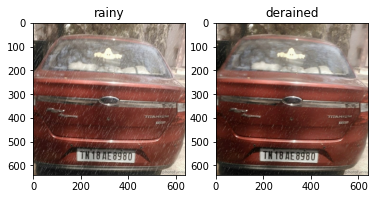

In [9]:
if __name__ == '__main__':
   imgName = os.listdir(img_path)
   num_img = len(imgName)
   print(num_img)
   
   whole_path = []
   for i in range(num_img):
      whole_path.append(img_path + imgName[i])
      
    
   filename_tensor = tf.convert_to_tensor(whole_path, dtype=tf.string)     
   dataset = tf.data.Dataset.from_tensor_slices((filename_tensor))
   dataset = dataset.map(_parse_function)    
   dataset = dataset.prefetch(buffer_size=10)
   dataset = dataset.batch(batch_size=1).repeat()  
   iterator = dataset.make_one_shot_iterator()
   
   rain = iterator.get_next() 


   output = Network.inference(rain, is_training = False)
   output = tf.clip_by_value(output, 0., 1.)
   output = output[0,:,:,:]

   config = tf.ConfigProto()
   config.gpu_options.allow_growth=True   
   saver = tf.train.Saver()


   with tf.Session(config=config) as sess: 
      with tf.device('/gpu:0'): 
          if tf.train.get_checkpoint_state(model_path):  
              ckpt = tf.train.latest_checkpoint(model_path)  # try your own model 
              saver.restore(sess, ckpt)
              print ("Loading model")
          else:
             saver.restore(sess, pre_trained_model_path) # try a pre-trained model 
             print ("Loading pre-trained model")

          for i in range(num_img):     
             derained, ori = sess.run([output, rain])              
             derained = np.uint8(derained* 255.)
             index = imgName[i].rfind('.')
             name = imgName[i][:index]
             #skimage.io.imsave(results_path + name +'.png', derained)         
             print('%d / %d images processed' % (i+1,num_img))
              
      print('All done')
   sess.close()   
   
   plt.subplot(1,2,1)     
   plt.imshow(ori[0,:,:,:])          
   plt.title('rainy')
   plt.subplot(1,2,2)    
   plt.imshow(derained)
   plt.title('derained')
   plt.show()     